# Online Shoppers Intention Prediction
**Objective**: To predict whether a user will make a purchase based on their browsing behavior.

Halladay Kinsey, Vivian Perng, and Daniel Grant




In [1]:
# Importing necessary libraries
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import roc_auc_score, log_loss, roc_curve, auc
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency
from sklearn.model_selection import RandomizedSearchCV

warnings.filterwarnings('ignore')

In [2]:
# Mounting drive
drive.mount('/content/drive')

Mounted at /content/drive


In [56]:
file_path = '/content/drive/My Drive/AAI510: Final Project/online_shoppers_intention.csv'
df = pd.read_csv(file_path)

# Exploratory Data Analysis

In [4]:
# Checking for missing values
missing_values = df.isnull().sum()
print("Missing Values in Dataset:\n", missing_values)

Missing Values in Dataset:
 Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64


### Overall Revenue Distribution

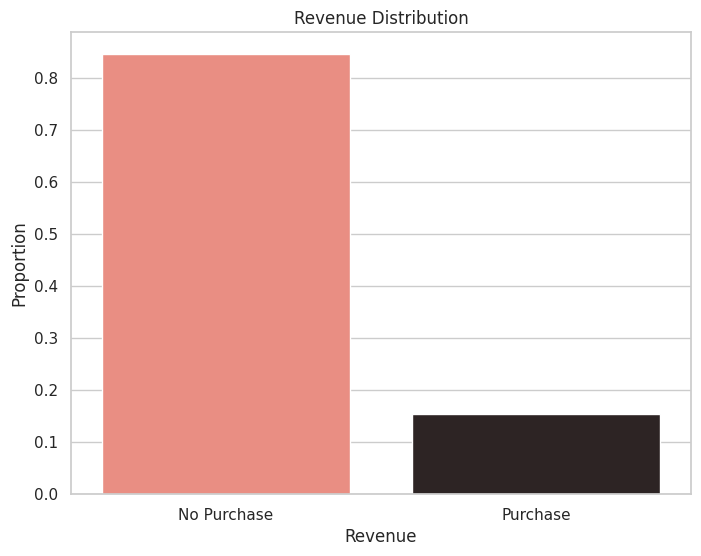

In [57]:
# Plotting distribution of Revenue
revenue_distribution = df['Revenue'].value_counts(normalize=True)

plt.figure(figsize=(8, 6))
sns.barplot(x=revenue_distribution.index, y=revenue_distribution.values, palette='dark:salmon_r')
plt.title('Revenue Distribution')
plt.xlabel('Revenue')
plt.ylabel('Proportion')
plt.xticks([0, 1], ['No Purchase', 'Purchase'])
plt.show()

### Summary Statistics

In [58]:
# Summary statistics for numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
summary_statistics = df[numerical_columns].describe()
print("Summary Statistics of Numerical Columns:\n", summary_statistics)

Summary Statistics of Numerical Columns:
        Administrative  Administrative_Duration  Informational  \
count    12330.000000             12330.000000   12330.000000   
mean         2.315166                80.818611       0.503569   
std          3.321784               176.779107       1.270156   
min          0.000000                 0.000000       0.000000   
25%          0.000000                 0.000000       0.000000   
50%          1.000000                 7.500000       0.000000   
75%          4.000000                93.256250       0.000000   
max         27.000000              3398.750000      24.000000   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
count            12330.000000    12330.000000             12330.000000   
mean                34.472398       31.731468              1194.746220   
std                140.749294       44.475503              1913.669288   
min                  0.000000        0.000000                 0.000000   
25

### Correlation

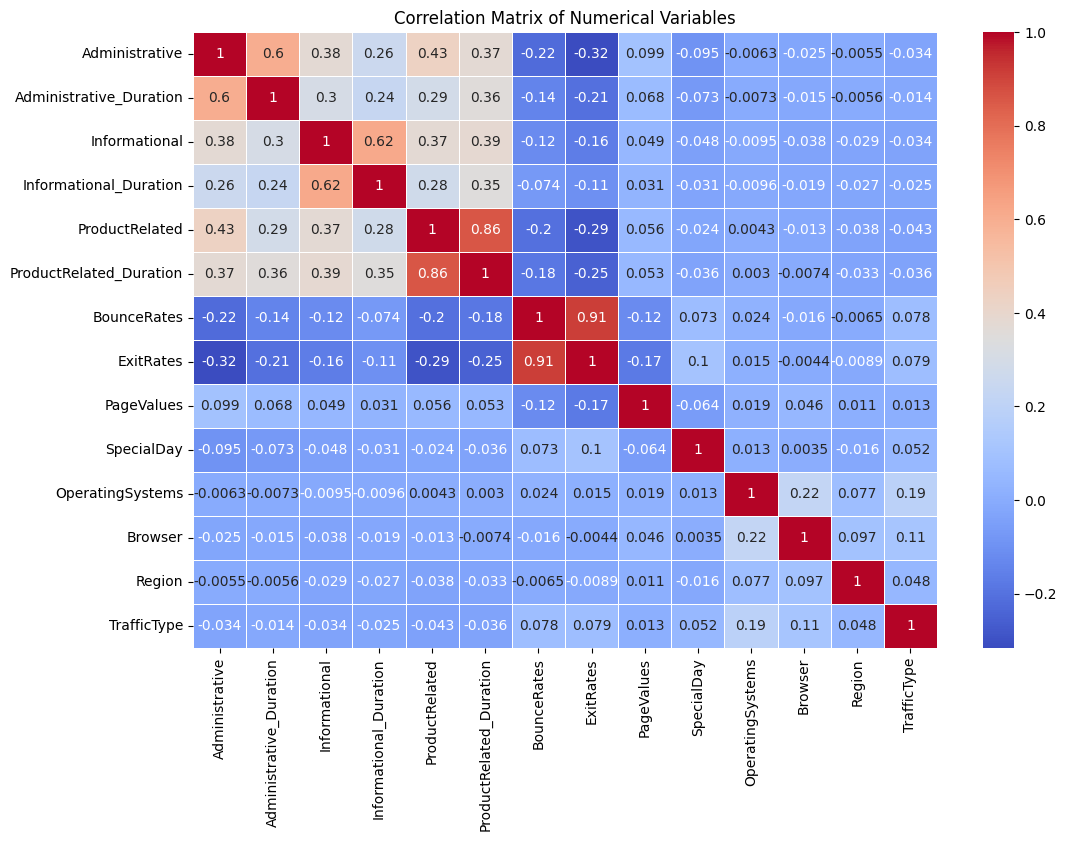

In [7]:
# Correlation matrix & heatmap
correlation_matrix = df[numerical_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

### Most correlated variables

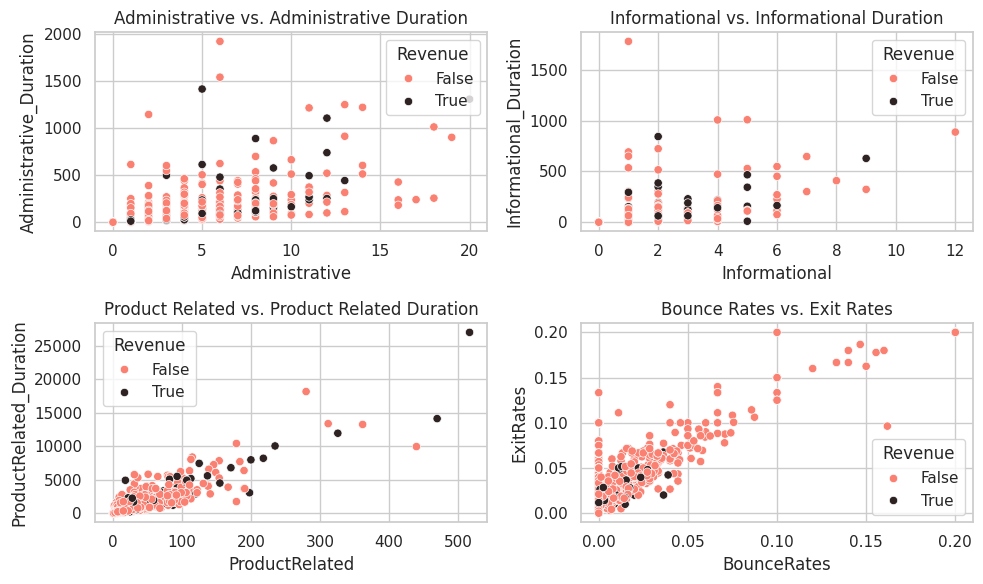

In [59]:
# Sampling data for overfitting
sampled_df = df.sample(1000, random_state=1)

plt.figure(figsize=(10, 6))

# Administrative vs. Administrative Duration
plt.subplot(2, 2, 1)
sns.scatterplot(data=sampled_df, x='Administrative', y='Administrative_Duration', hue='Revenue', palette='dark:salmon_r')
plt.title('Administrative vs. Administrative Duration')

# Informational vs. Informational Duration
plt.subplot(2, 2, 2)
sns.scatterplot(data=sampled_df, x='Informational', y='Informational_Duration', hue='Revenue', palette='dark:salmon_r')
plt.title('Informational vs. Informational Duration')

# Product Related vs. Product Related Duration
plt.subplot(2, 2, 3)
sns.scatterplot(data=sampled_df, x='ProductRelated', y='ProductRelated_Duration', hue='Revenue', palette='dark:salmon_r')
plt.title('Product Related vs. Product Related Duration')

# Bounce Rates vs. Exit Rates
plt.subplot(2, 2, 4)
sns.scatterplot(data=sampled_df, x='BounceRates', y='ExitRates', hue='Revenue', palette='dark:salmon_r')
plt.title('Bounce Rates vs. Exit Rates')

plt.tight_layout()
plt.show()

### Outlier Check

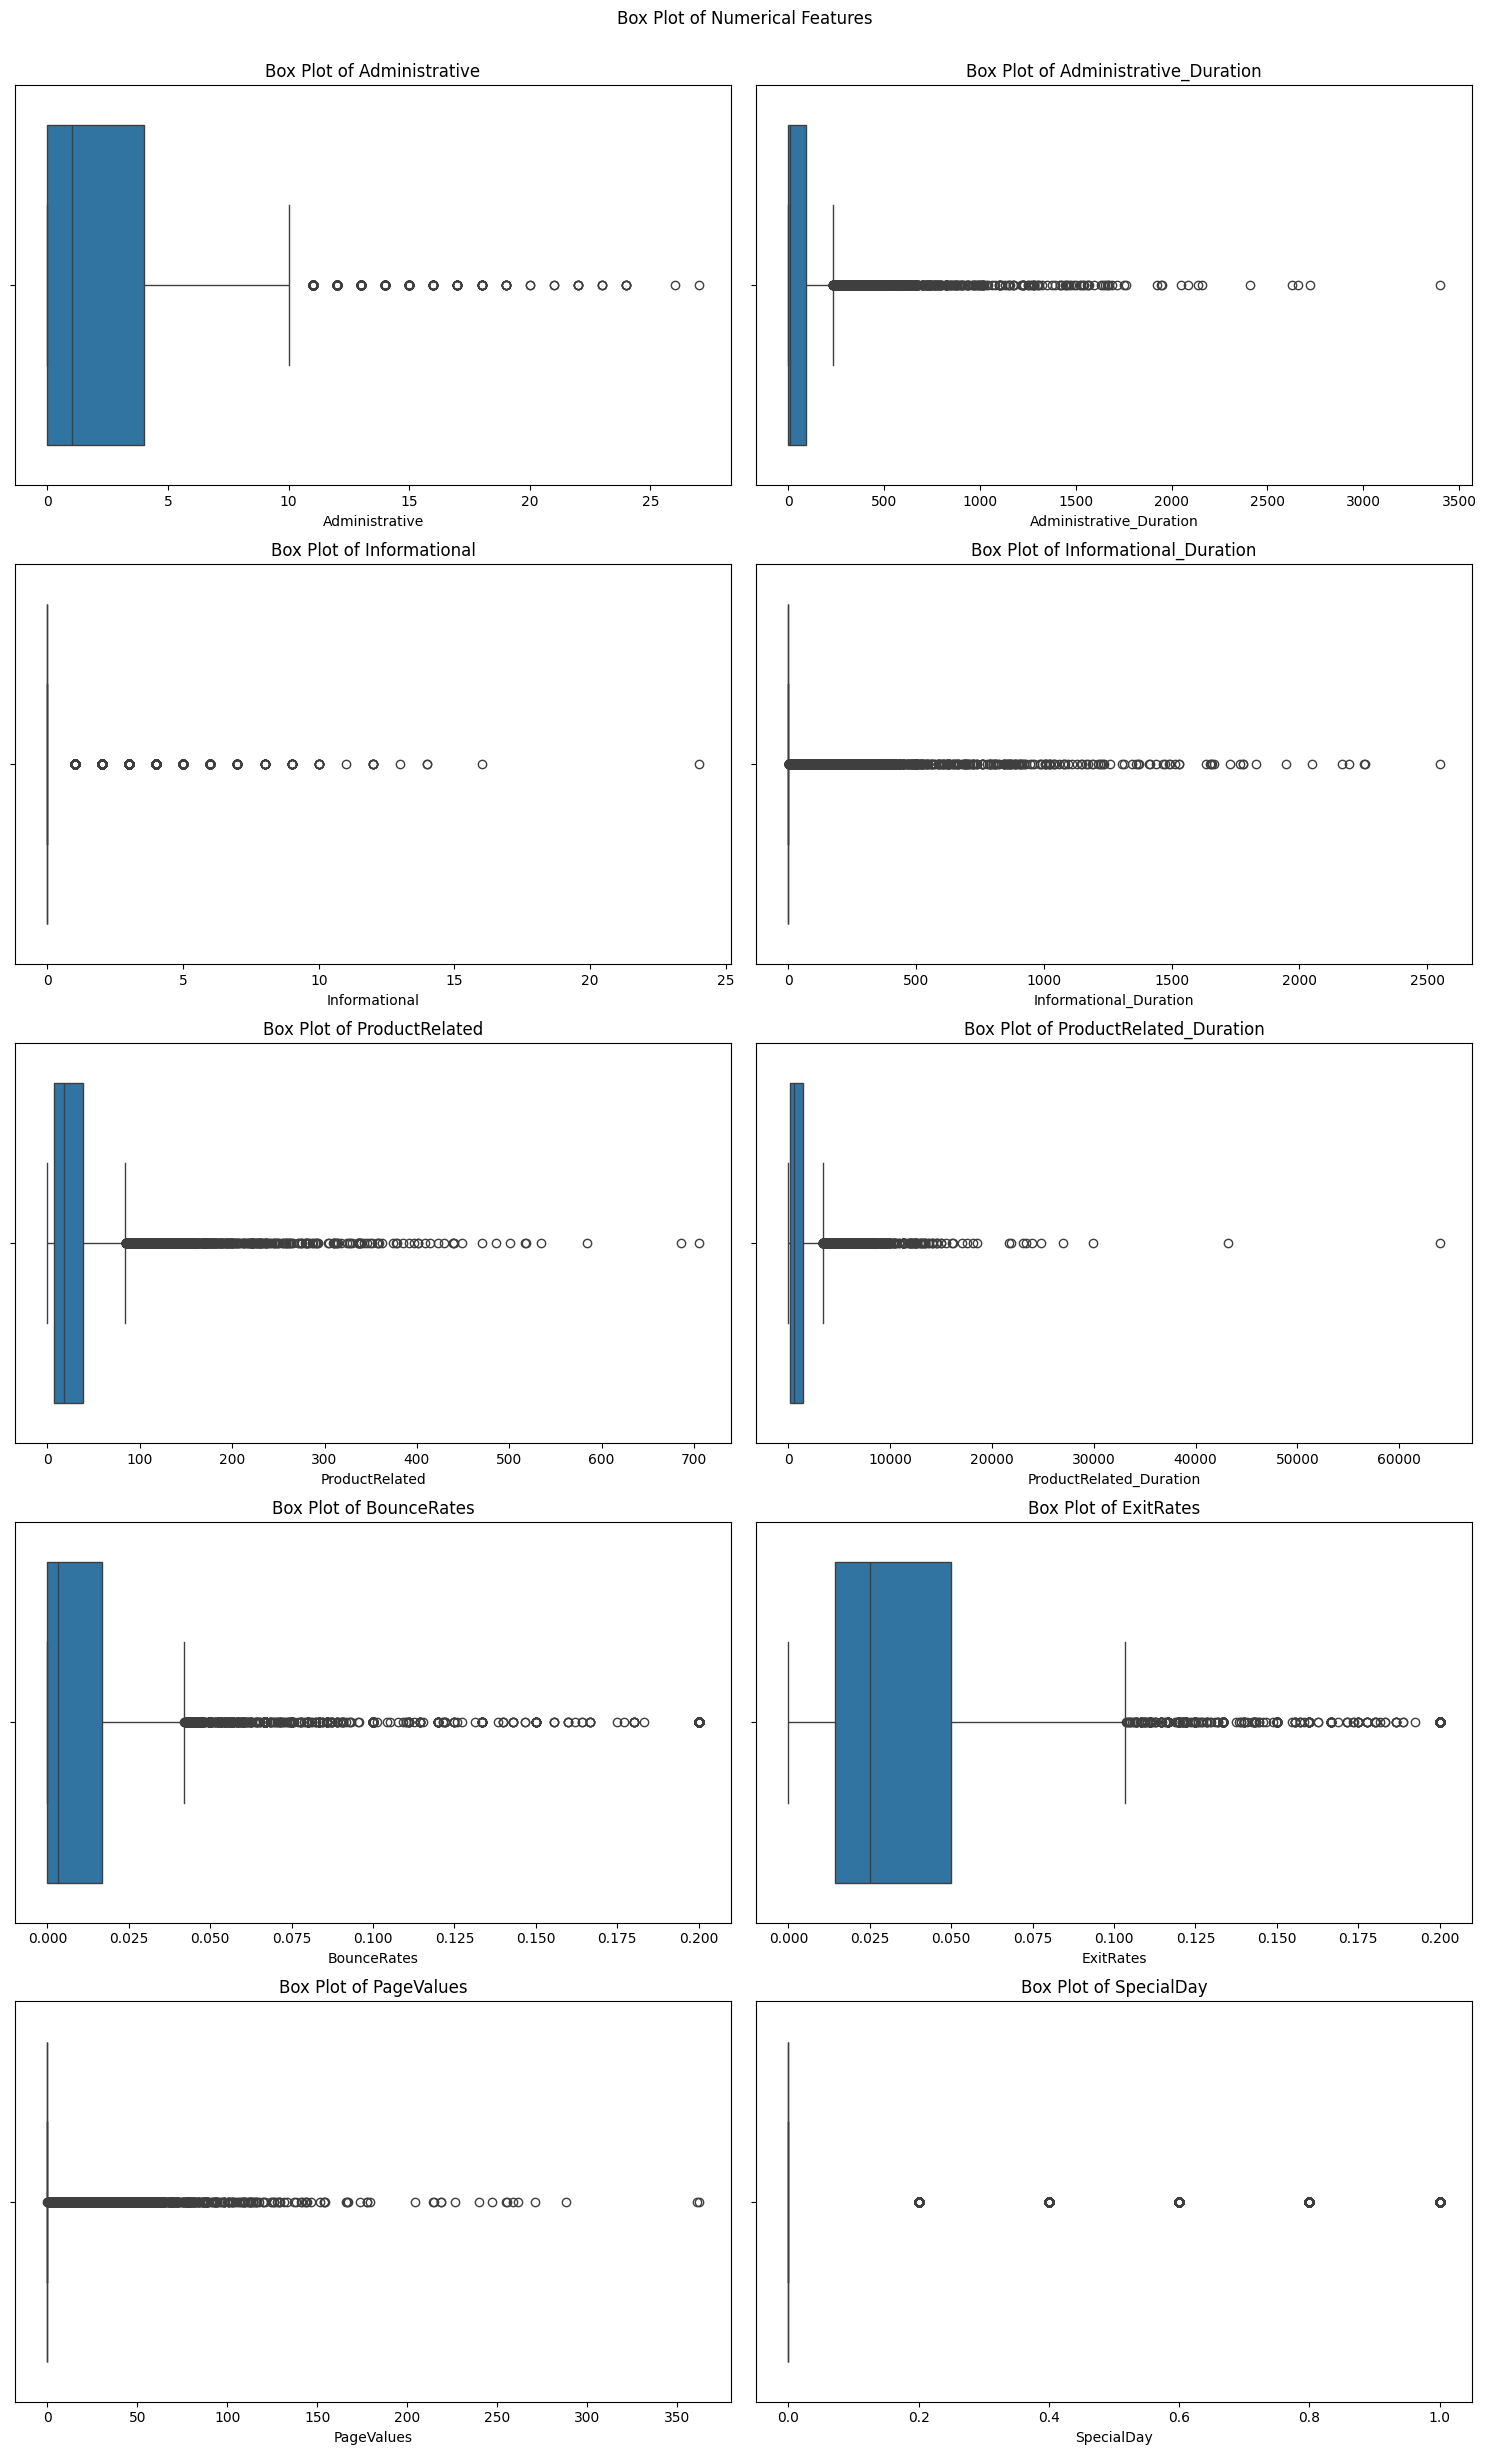

In [9]:
# List of numerical columns to plot
numerical_cols = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
                  'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

fig, axes = plt.subplots(5, 2, figsize=(15, 25))
fig.suptitle('Box Plot of Numerical Features')

# Iterating over numerical columns
for col, ax in zip(numerical_cols, axes.flatten()):
    sns.boxplot(data=df, x=col, ax=ax)
    ax.set_title(f'Box Plot of {col}')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

### Distribution of Numerical Variables

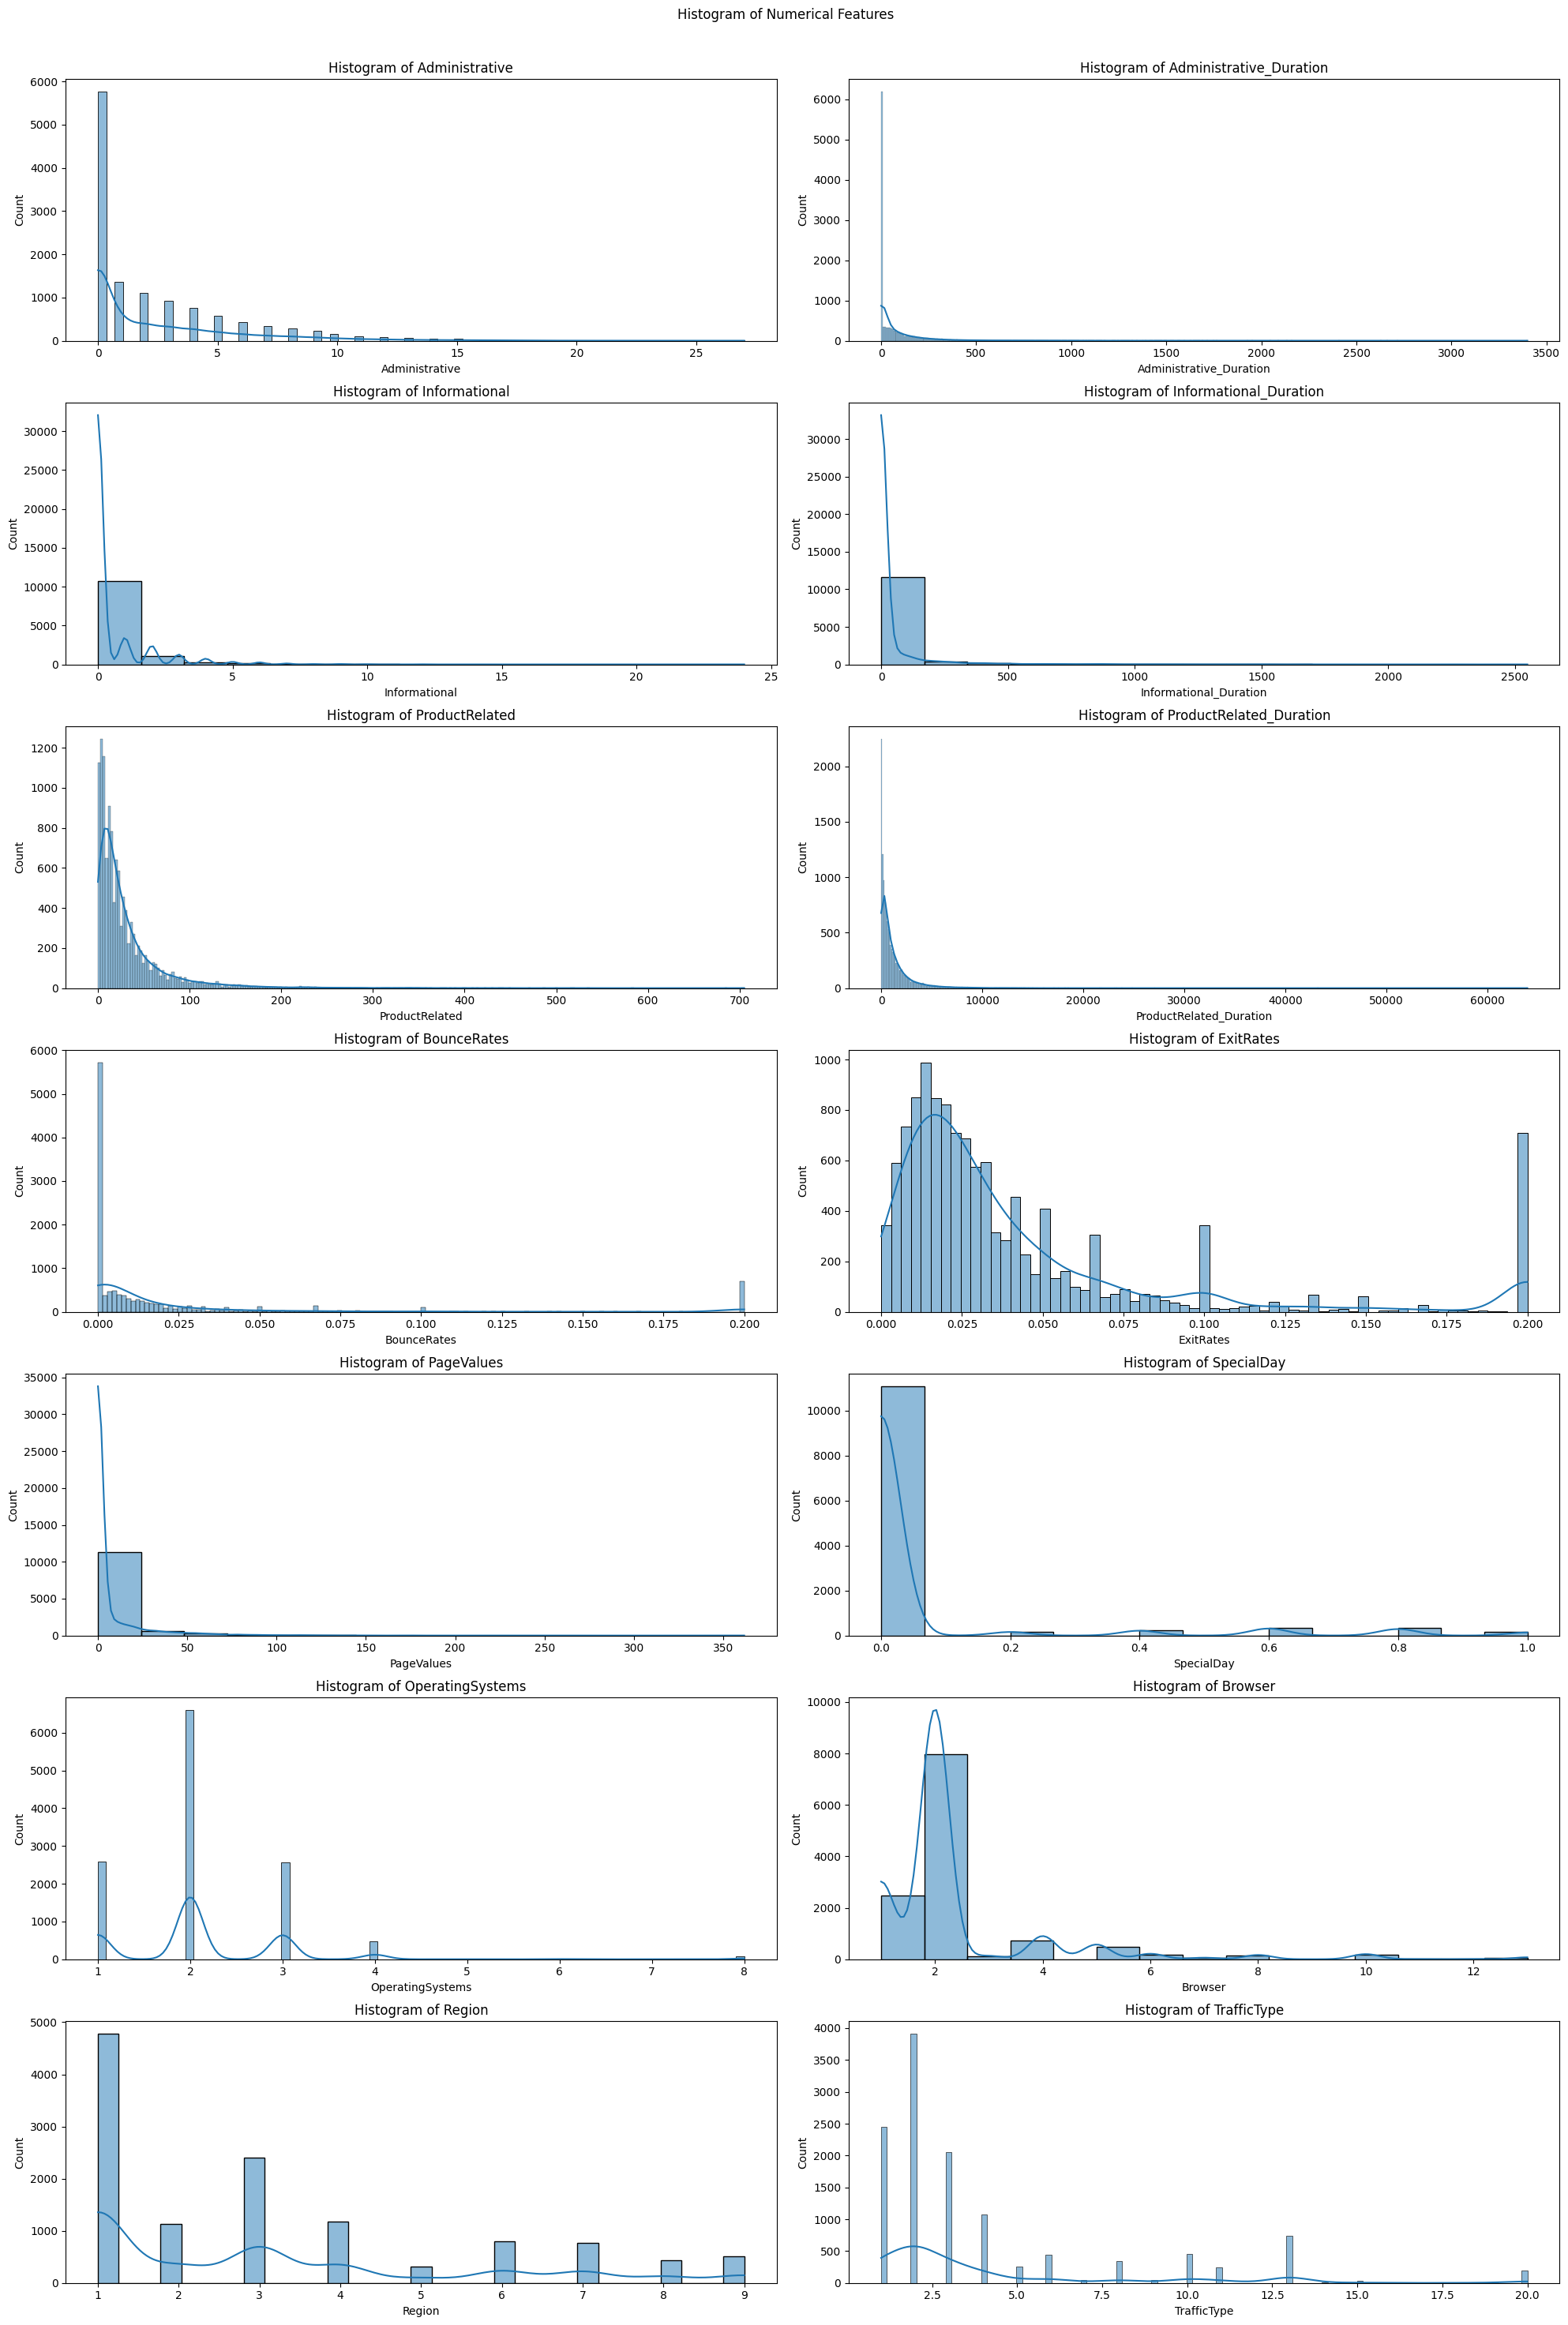

In [10]:
# List of all numerical columns
numerical_list = numerical_columns.tolist()

fig, axes = plt.subplots(7, 2, figsize=(20, 30))
fig.suptitle('Histogram of Numerical Features')

# Iterating over numerical columns
for col, ax in zip(numerical_list, axes.flatten()):
    sns.histplot(data=df, x=col, ax=ax, kde=True)
    ax.set_title(f'Histogram of {col}')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

### Comparison of Distributions of Target Variable for Numerical Columns

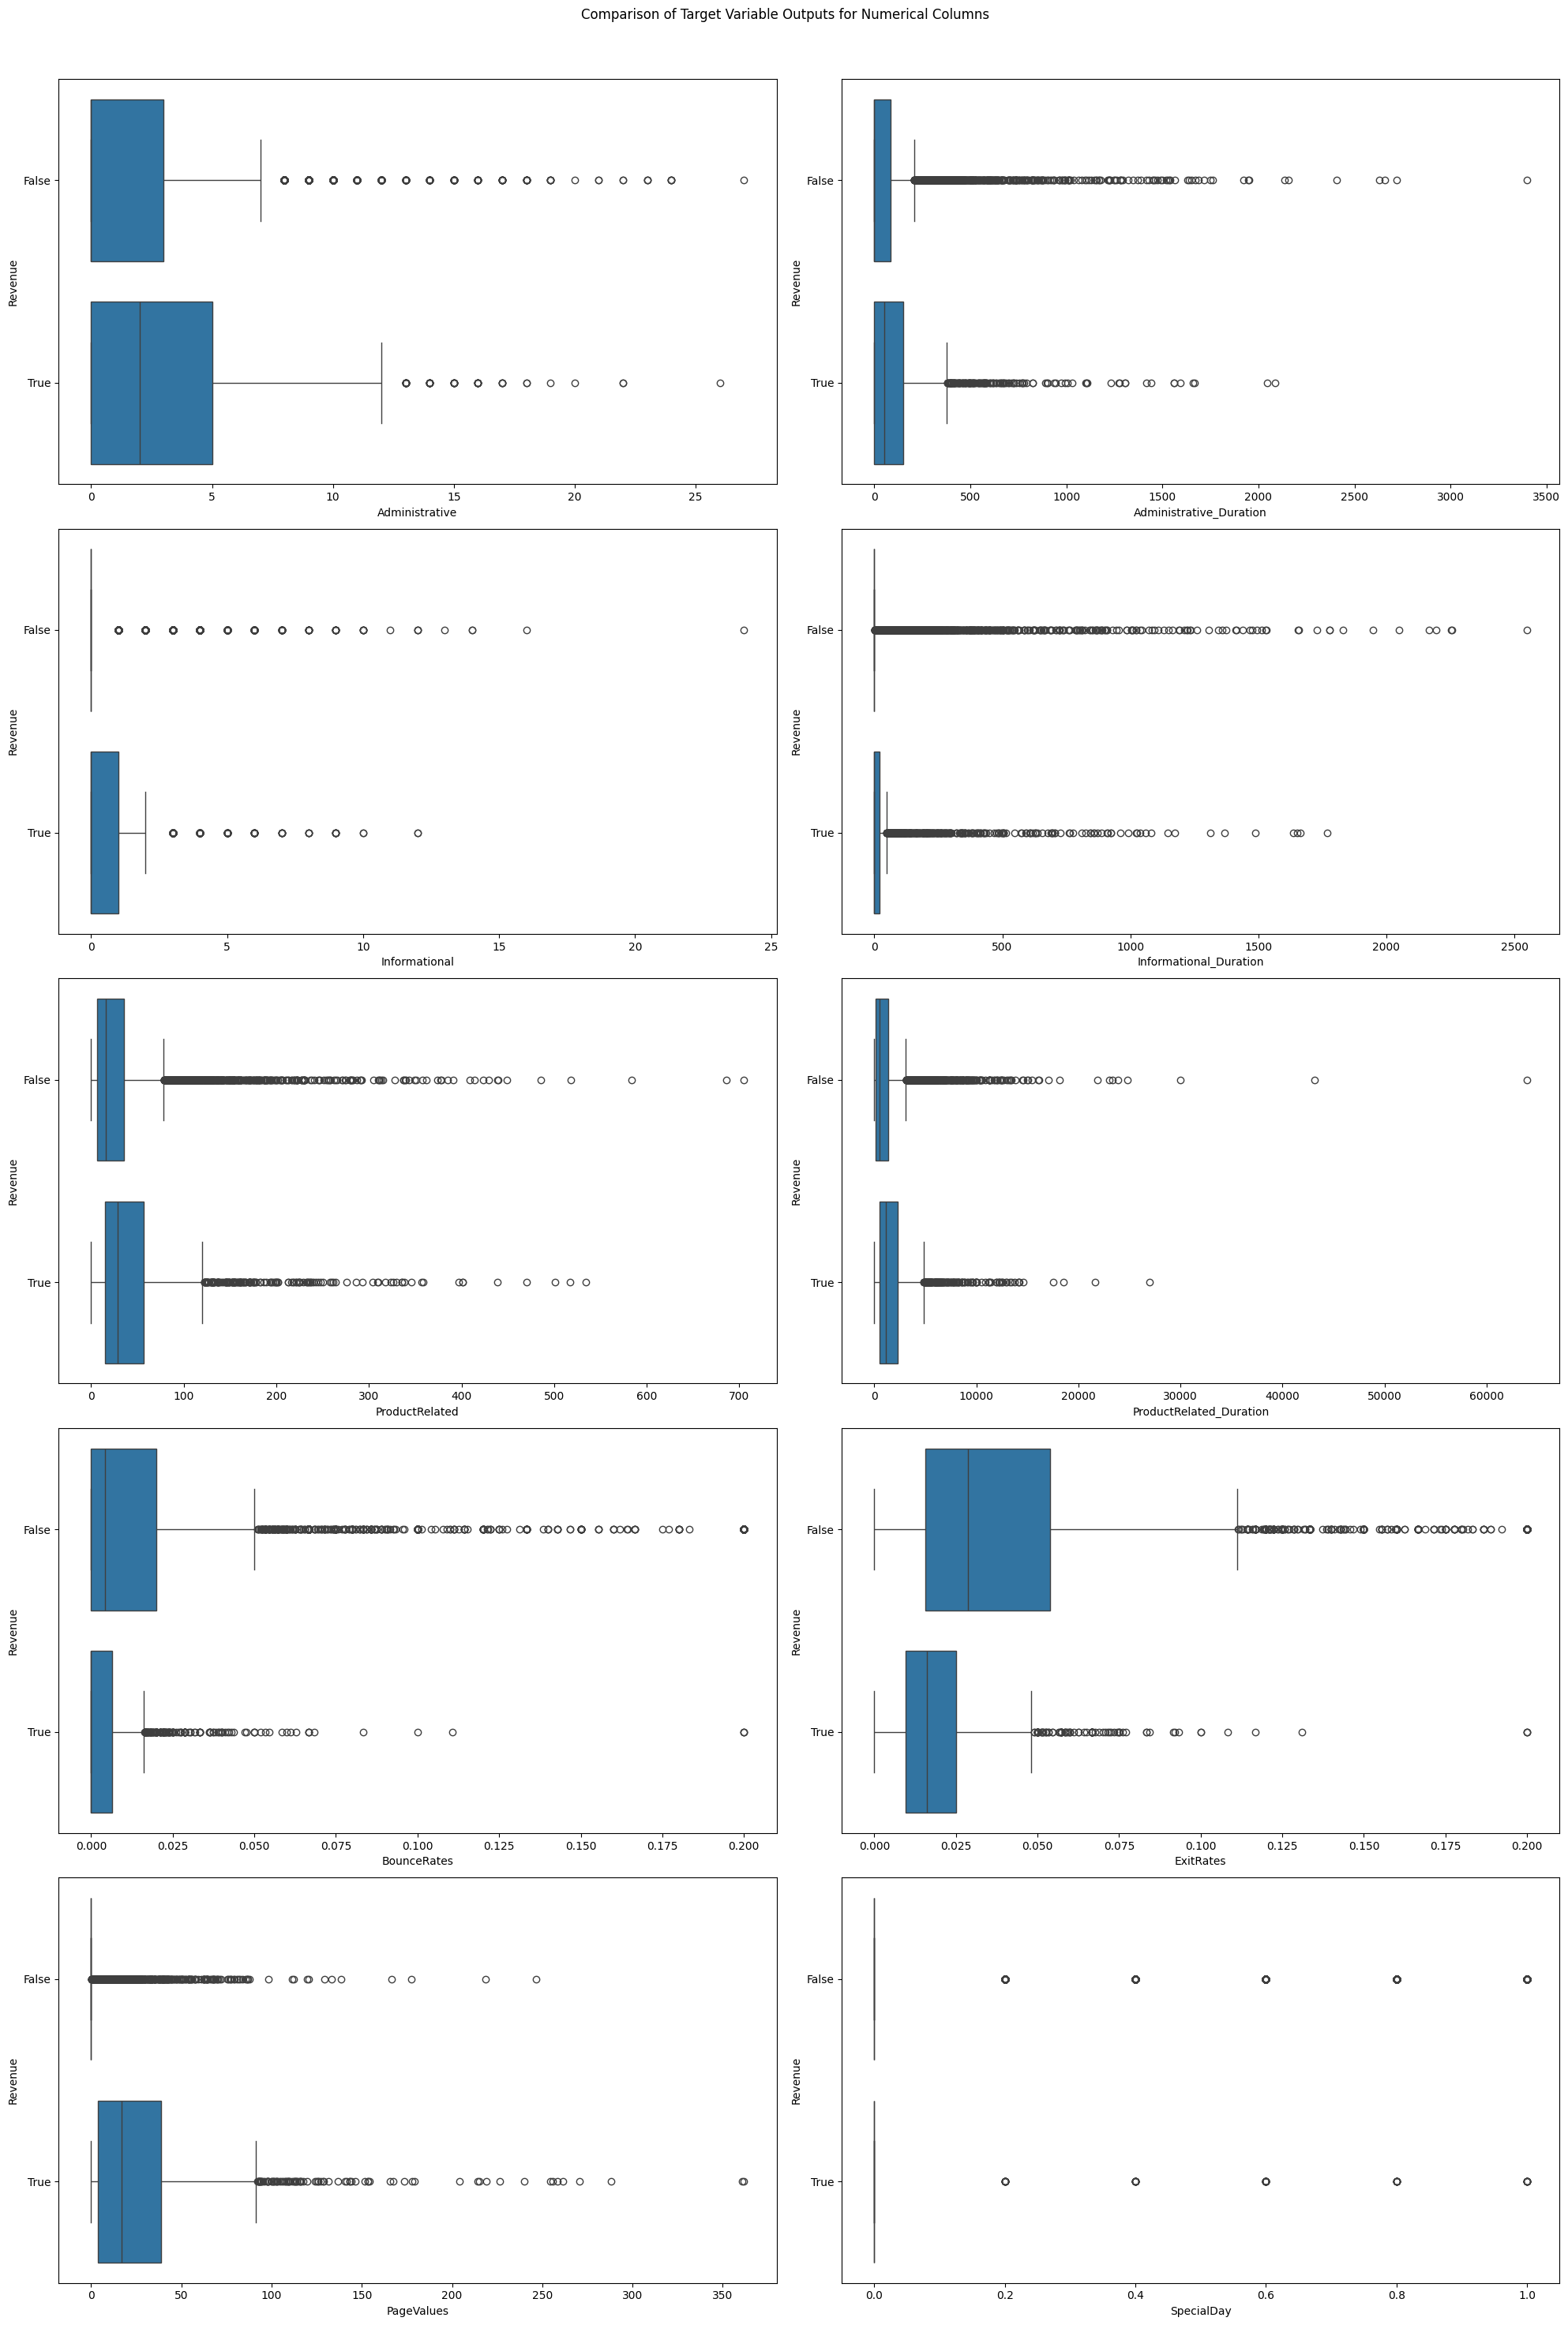

In [11]:
fig, axes = plt.subplots(5, 2, figsize=(20, 30))
fig.suptitle('Comparison of Target Variable Outputs for Numerical Columns')

# Create box plots comparing False Revenue and True Revenue for each feature
for col, ax in zip(numerical_cols, axes.flatten()):
    sns.boxplot(x=col, y='Revenue', data=df, ax=ax, orient='h')
    plt.ylabel('Revenue')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

## Categorical Columns

### Distribution

In [12]:
# Distribution of categorical variables
categorical_columns = df.select_dtypes(include=['object', 'bool']).columns
categorical_distributions = {}
for col in categorical_columns:
    categorical_distributions[col] = df[col].value_counts()
for col, value_counts in categorical_distributions.items():
    print(f"Distribution of {col}:\n{value_counts}\n")
# categorical_distributions = df[categorical_columns].apply(lambda x: x.value_counts())
# print("Distribution of Categorical Variables:\n", categorical_distributions)

Distribution of Month:
Month
May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: count, dtype: int64

Distribution of VisitorType:
VisitorType
Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: count, dtype: int64

Distribution of Weekend:
Weekend
False    9462
True     2868
Name: count, dtype: int64

Distribution of Revenue:
Revenue
False    10422
True      1908
Name: count, dtype: int64



### Distribution by Revenue

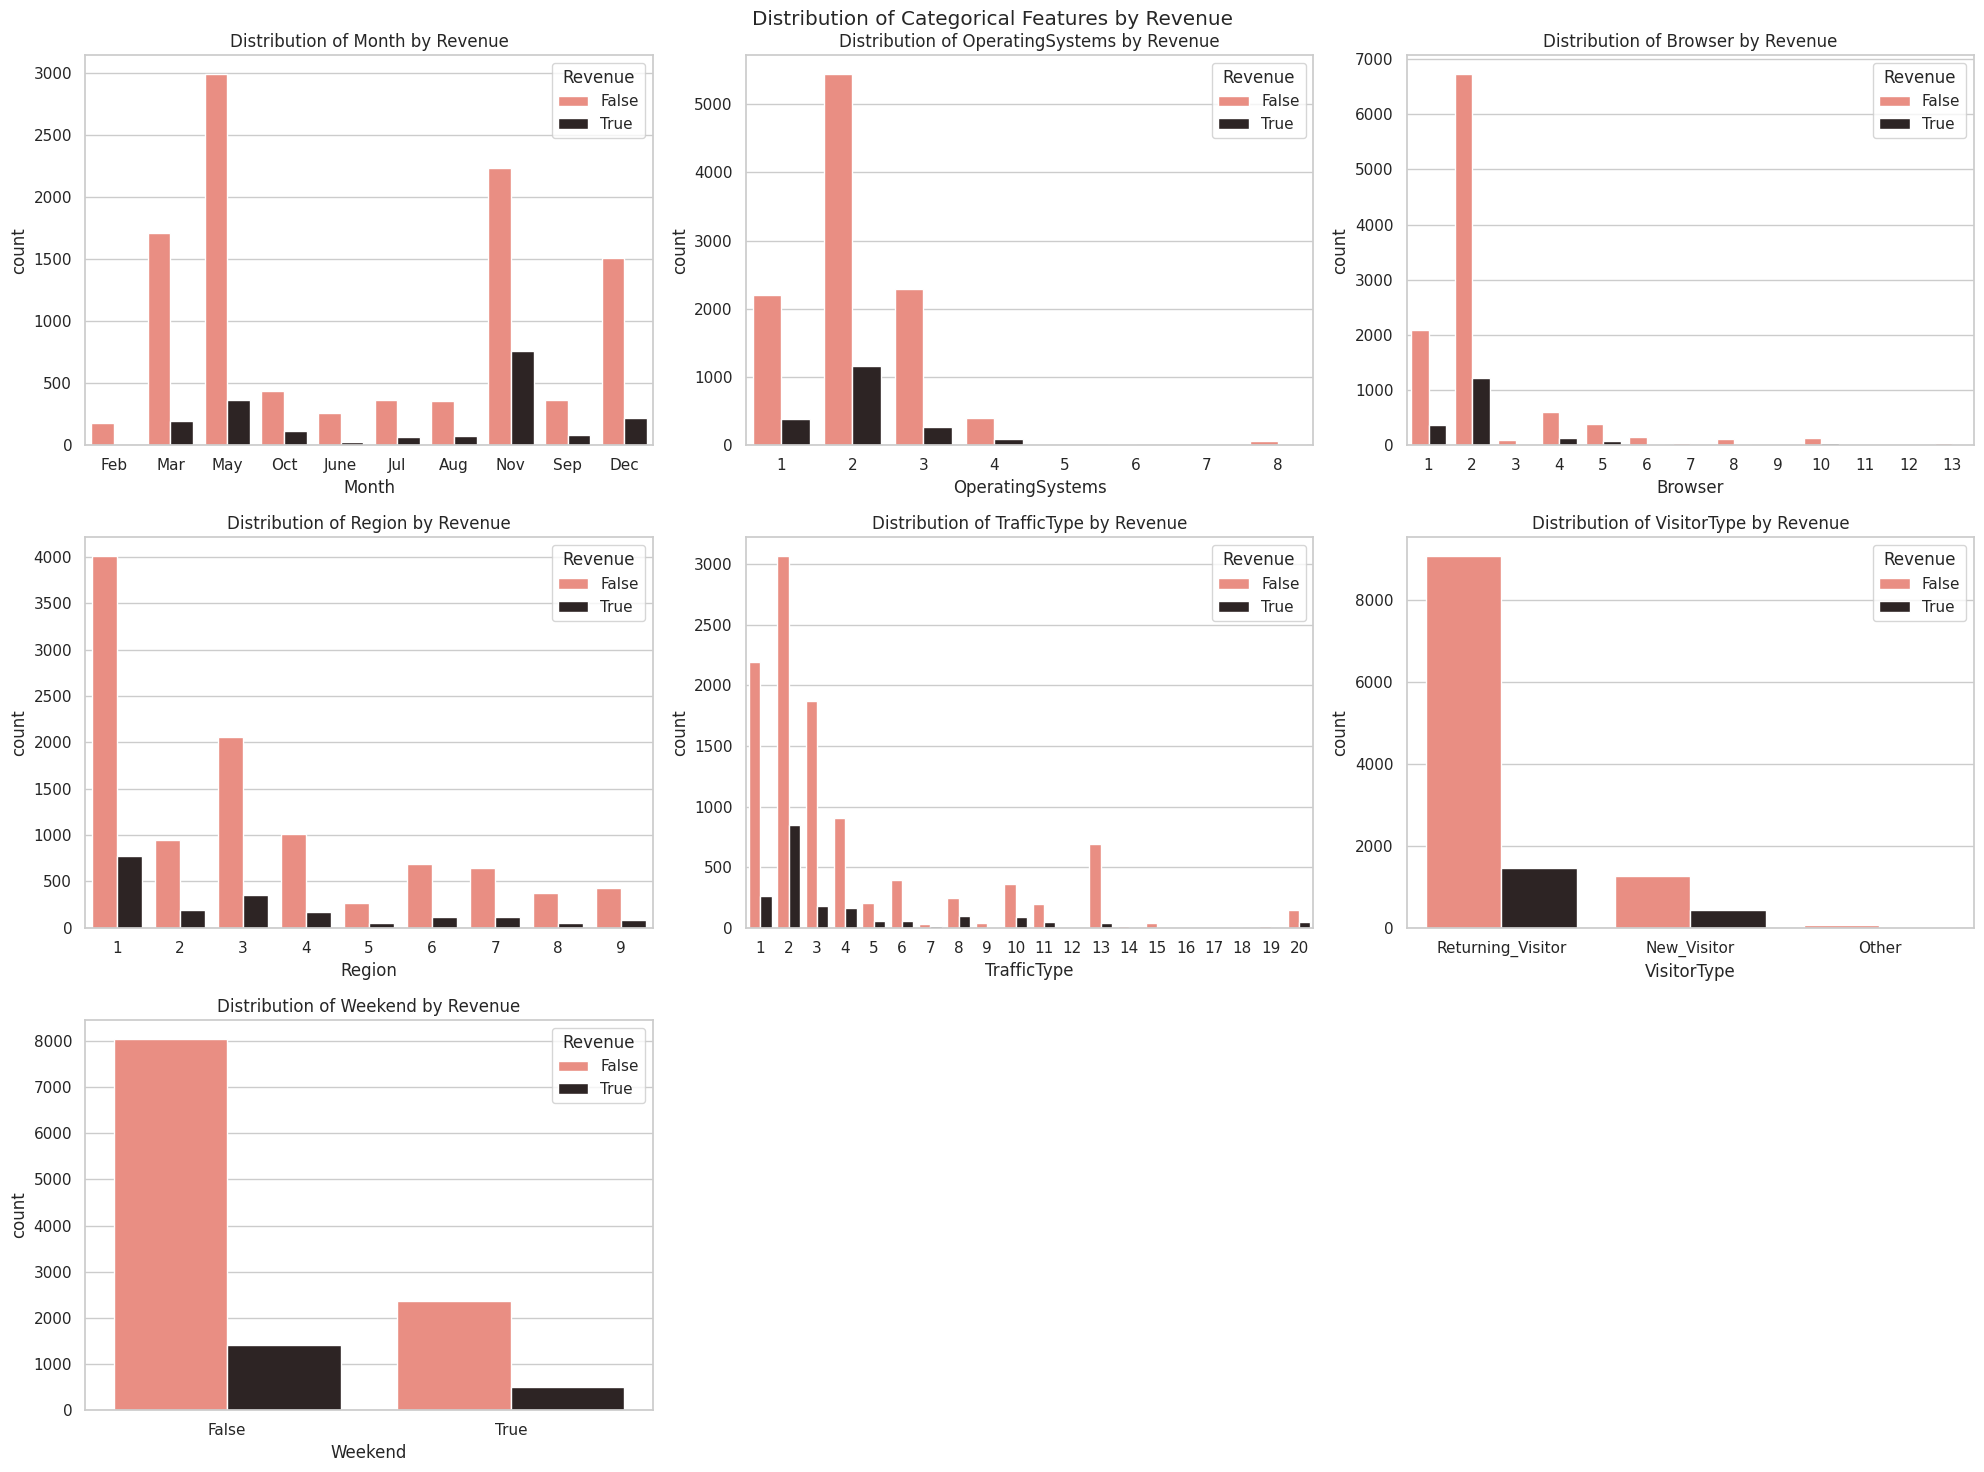

In [60]:
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Distribution of Categorical Features by Revenue')

# Categorical columns
categorical_cols = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']

# Iterating over categorical columns
for col, ax in zip(categorical_cols, axes.flatten()):
    sns.countplot(data=df, x=col, hue='Revenue', palette='dark:salmon_r', ax=ax)
    ax.set_title(f'Distribution of {col} by Revenue')
    ax.legend(title='Revenue', loc='upper right')

# Removing empty subplots
for i in range(len(categorical_cols), 9):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

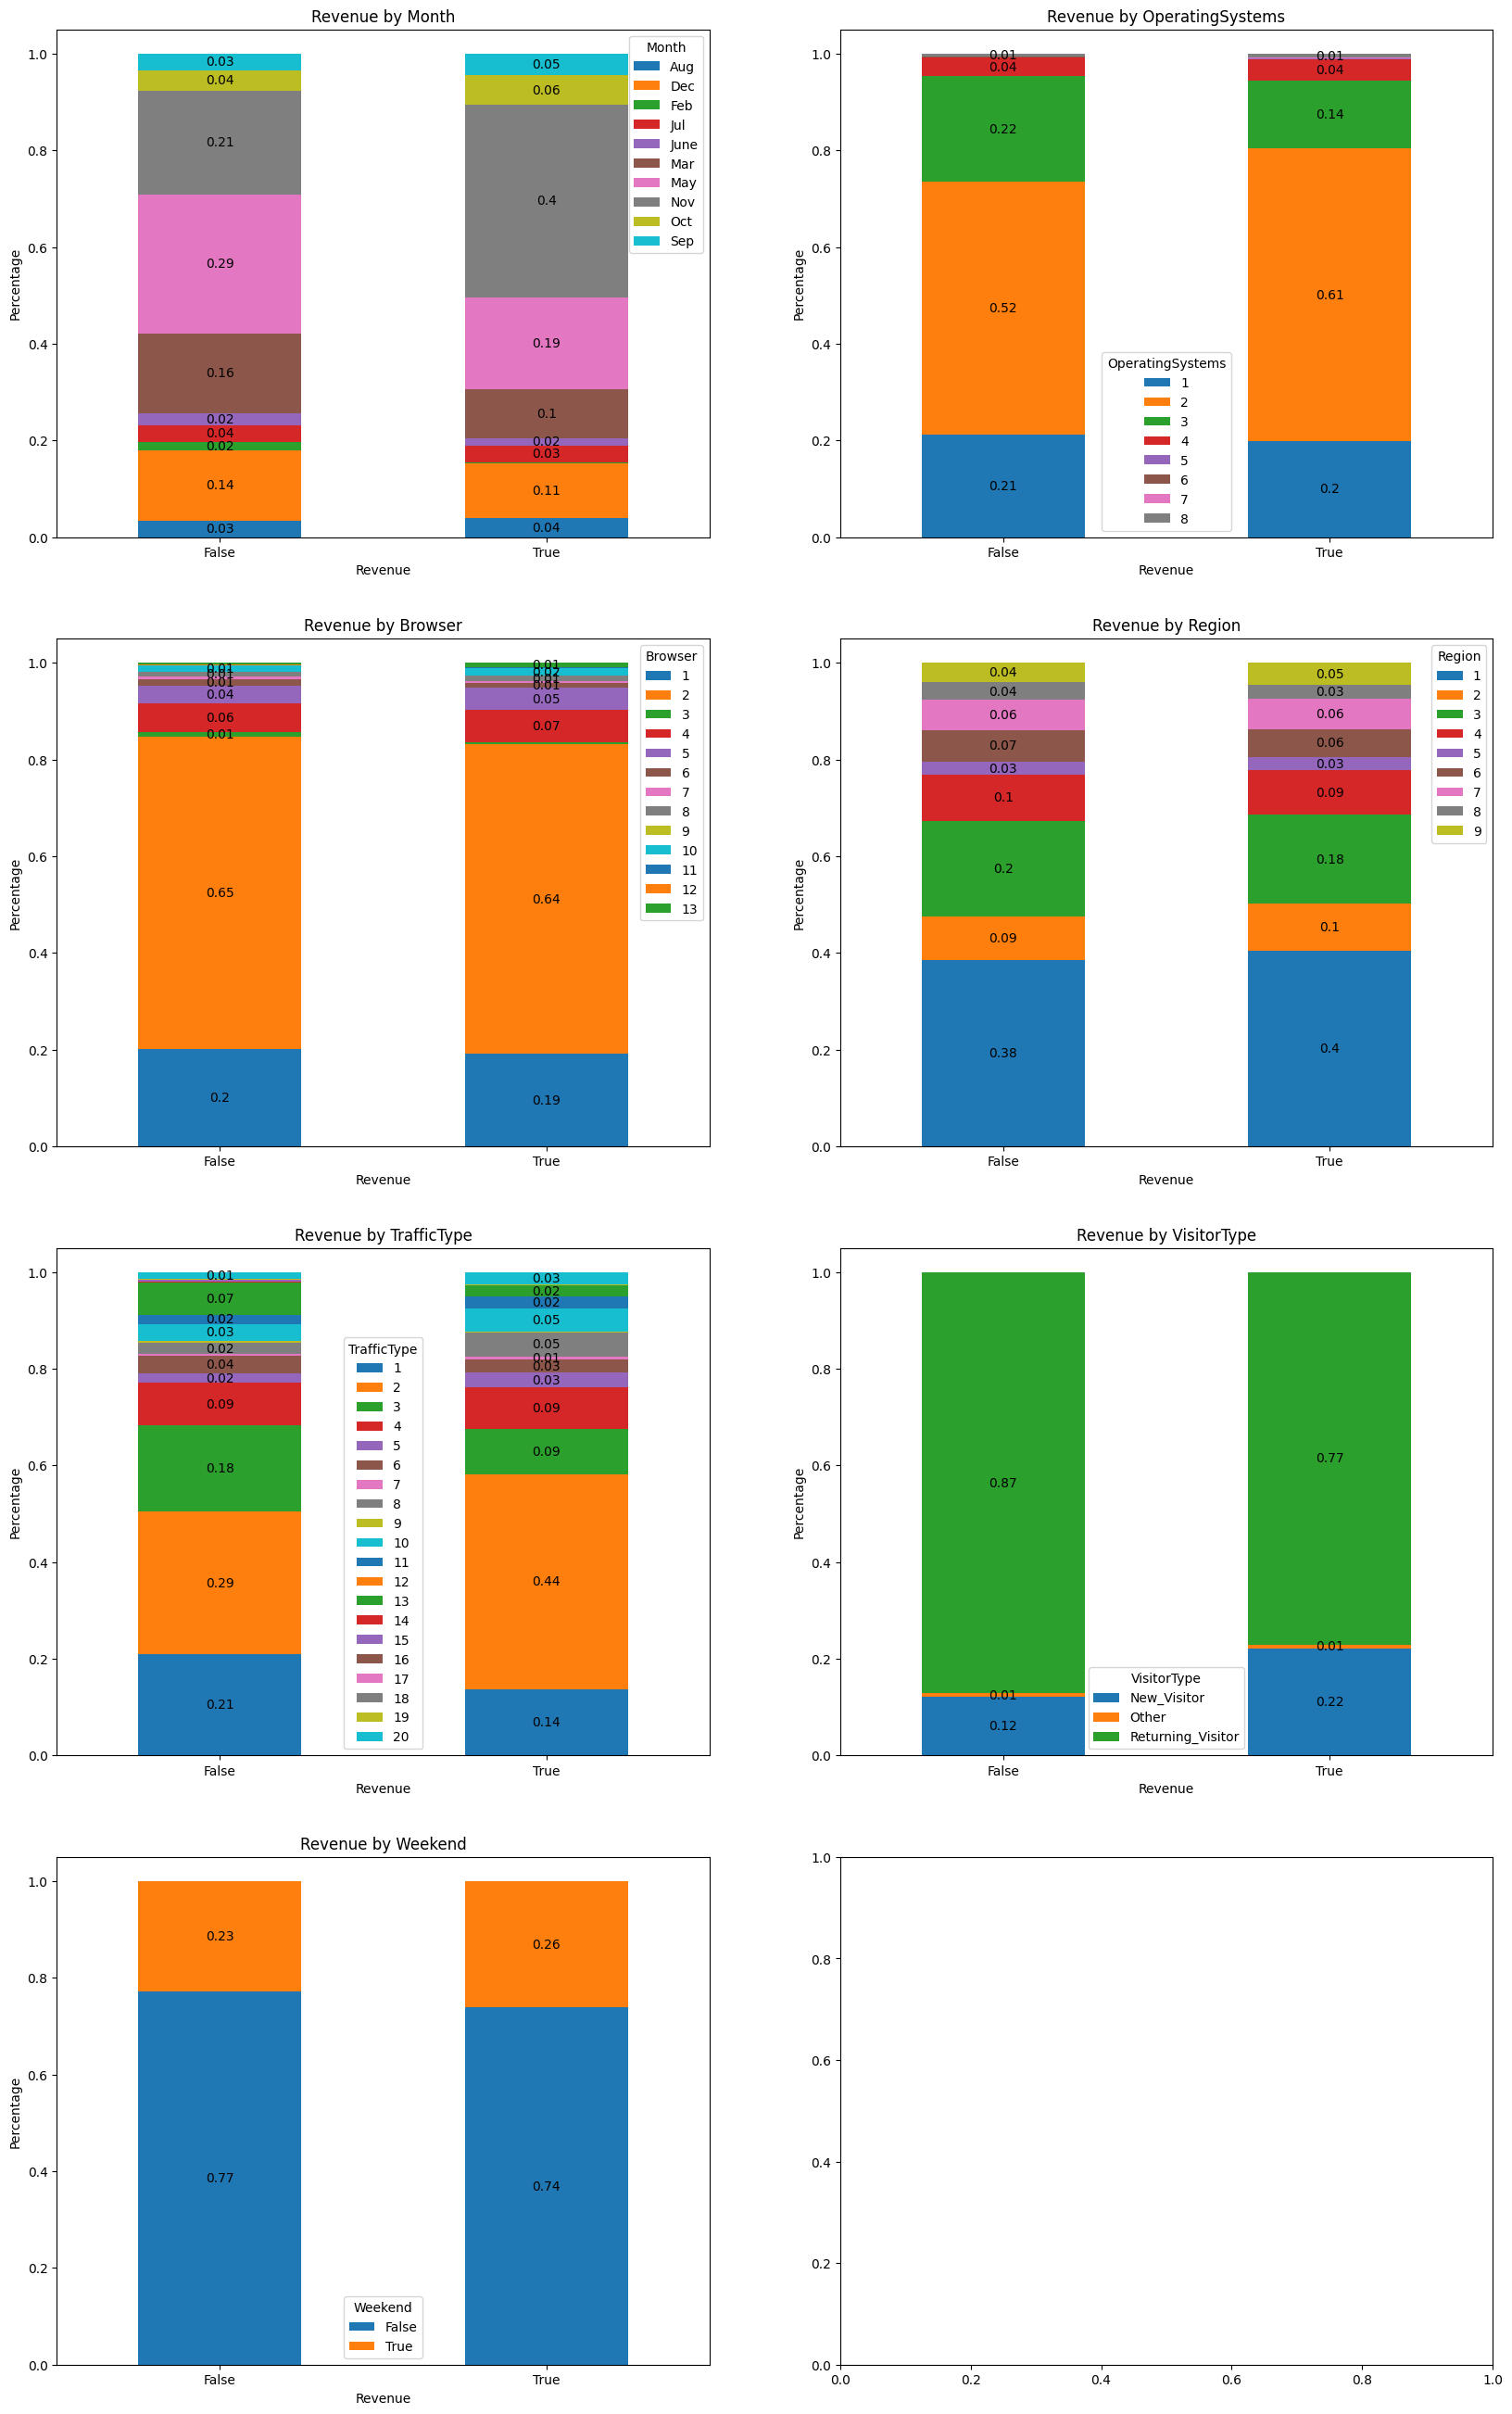

In [14]:
#Prepared data for visualization
def percent_of_total(second_column):
    percent = df.groupby(['Revenue', second_column]).size().unstack().fillna(0)
    for i in range(len(percent)):
        percent.iloc[i,:] = percent.iloc[i,:]/sum(percent.iloc[i,:])
    return percent

# Create box plots comparing False Revenue and True Revenue for each feature
fig, axes = plt.subplots(4, 2, figsize=(20, 30))
for col, ax in zip(categorical_cols, axes.flatten()):
    percentage = percent_of_total(col)
    plot = percentage.plot(ax=ax, kind = 'bar', stacked = True, xlabel = 'Revenue',
                    ylabel = 'Percentage', title = 'Revenue by {}'.format(col), rot =0)
    #label each stack with percentage
    for c in plot.containers:
        labels = [round(v.get_height(),2) if round(v.get_height(),2) > 0 else '' for v in c]
        plot.bar_label(c, labels = labels, label_type = 'center')

plt.subplots_adjust(top=0.95)
plt.show()

### Correlation between Categorical Variables

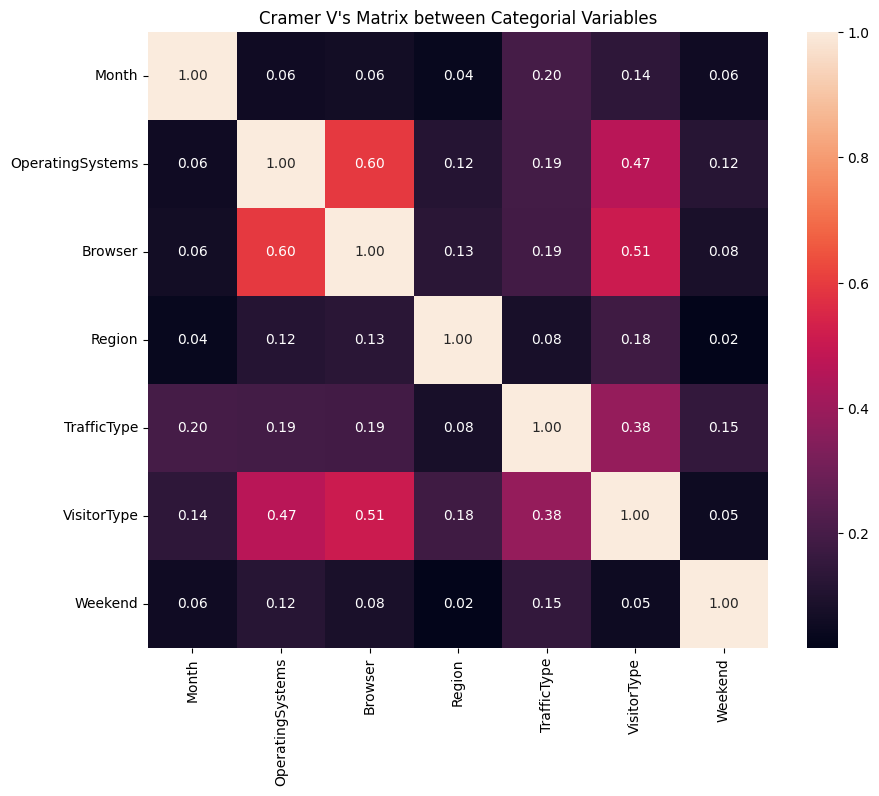

In [15]:
def cramers_v(x,y):
    # Create contingency table
    contingency_table = pd.crosstab(x,y)
    # Calculate chi-square statistic
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    # Cramer's V calculation
    phi2 = chi2/n
    r, k = contingency_table.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min(k_corr-1, r_corr-1))

# Initialize matrix
cramers_v_matrix = pd.DataFrame(np.zeros((len(categorical_cols), len(categorical_cols))),
                                index=categorical_cols, columns=categorical_cols)

# Loop over variables to fill in the matrix
for i, var1 in enumerate(categorical_cols):
    for j, var2 in enumerate(categorical_cols):
        if i >= j:
           # Cramer's V is symmetric, considering the same pair only once
            if i == j: # Diagonal elements are maximum
                cramers_v_matrix.loc[var1, var2] = 1.0
            else:
                cramers_v_val = cramers_v(df[var1], df[var2])
                cramers_v_matrix.loc[var1, var2] = cramers_v_val
                cramers_v_matrix.loc[var2, var1] = cramers_v_val

# Create a heatmap of the Cramer's V matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_matrix, annot=True, fmt=".2f")
plt.title("Cramer V's Matrix between Categorial Variables")
plt.show()

New Features

In [16]:
# seasons and quarters
season_mapping = {
    'Jan': 'Winter', 'Feb': 'Winter', 'Mar': 'Spring',
    'Apr': 'Spring', 'May': 'Spring', 'Jun': 'Summer',
    'Jul': 'Summer', 'Aug': 'Summer', 'Sep': 'Fall',
    'Oct': 'Fall', 'Nov': 'Fall', 'Dec': 'Winter'
}
df['Season'] = df['Month'].map(season_mapping)

quarter_mapping = {
    'Jan': 'Q1', 'Feb': 'Q1', 'Mar': 'Q1',
    'Apr': 'Q2', 'May': 'Q2', 'Jun': 'Q2',
    'Jul': 'Q3', 'Aug': 'Q3', 'Sep': 'Q3',
    'Oct': 'Q4', 'Nov': 'Q4', 'Dec': 'Q4'
}
df['Quarter'] = df['Month'].map(quarter_mapping)

df['IsHolidayMonth'] = df['Month'].apply(lambda x: 1 if x in ['Nov', 'Dec'] else 0) # thanksgiving and christmas months only

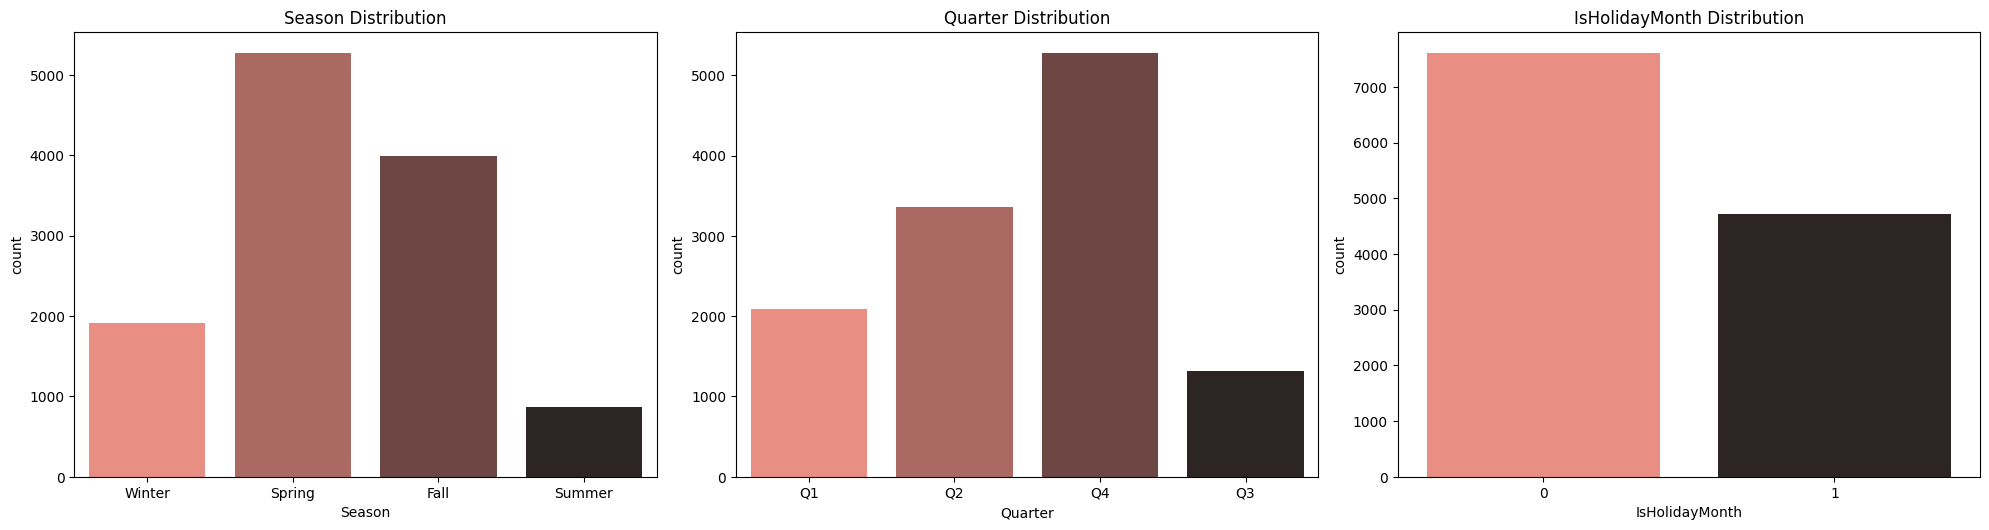

In [17]:
# distribution plots
plt.figure(figsize=(20, 10))

# seasons
plt.subplot(2, 3, 1)
sns.countplot(data=df, x='Season', palette='dark:salmon_r')
plt.title('Season Distribution')

# quarters
plt.subplot(2, 3, 2)
sns.countplot(data=df, x='Quarter', palette='dark:salmon_r')
plt.title('Quarter Distribution')

# IsHolidayMonth
plt.subplot(2, 3, 3)
sns.countplot(data=df, x='IsHolidayMonth', palette='dark:salmon_r')
plt.title('IsHolidayMonth Distribution')

plt.tight_layout()
plt.show()

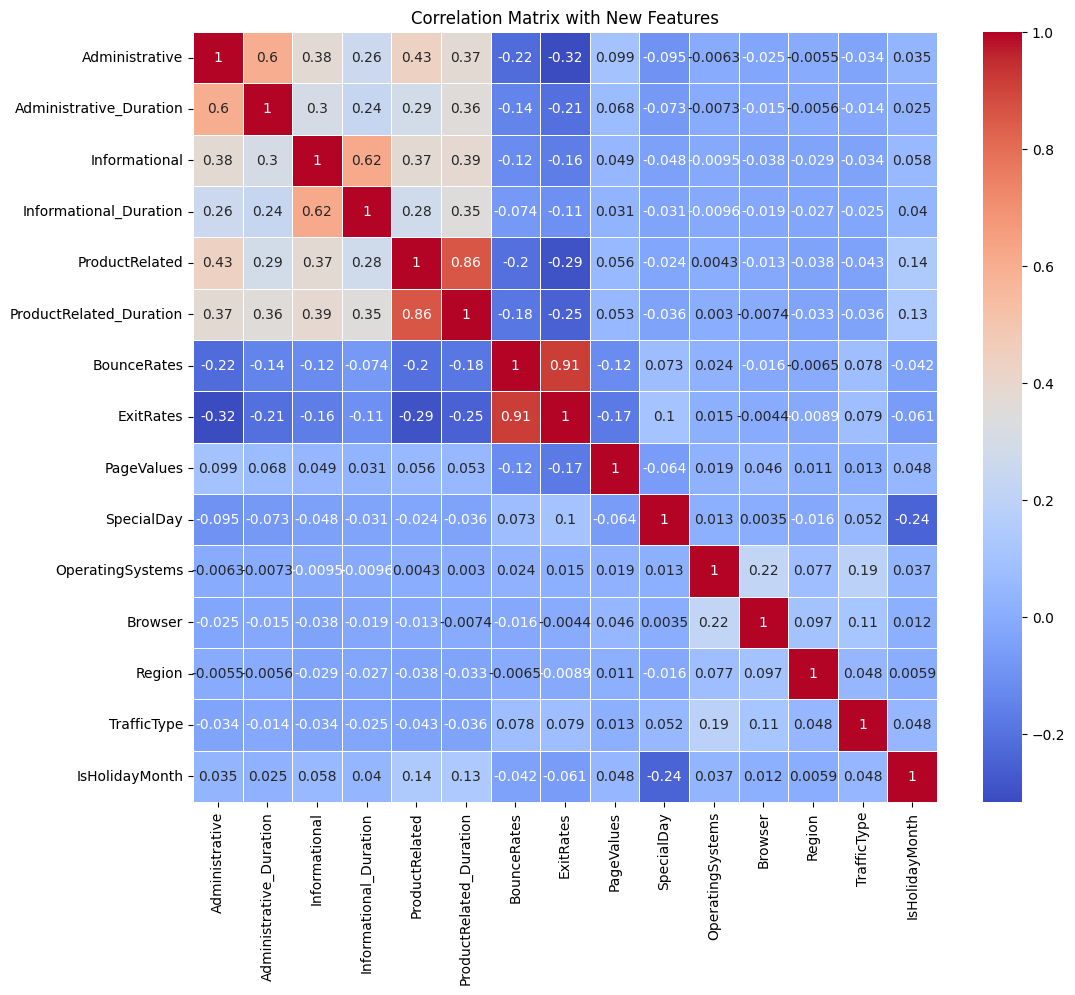

In [18]:
# correlation w/ new features
numerical_df = df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(12, 10))
correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix with New Features')
plt.show()

## Findings from Visualizations

### Correlation Matrix with New Features
- **BounceRates** and **ExitRates** are highly correlated (0.91).
- **ProductRelated** and **ProductRelated_Duration** also show a strong correlation (0.86).
- Most other features have low to moderate correlations.

### Season, Quarter, and IsHolidayMonth Distributions
- Spring has the highest count, followed by Fall, Winter, and Summer.
- Q4 and Q2 have the highest counts

### Distribution of Categorical Features by Revenue
- **Month**: May and November have the highest number of purchases.
- **Operating Systems**: Most purchases are from users using Operating System 1, followed by OS 2 and OS 3.
- **Browser**: Browser 2 has the highest number of purchases, followed by Browser 1.
- **Region**: Region 1 has the highest number of purchases.
- **TrafficType**: Traffic type 2 has the highest number of purchases.
- **VisitorType**: Returning visitors have a significantly higher number of purchases compared to new visitors.

### Histogram of Numerical Features
- Most features, like **Administrative, Informational, ProductRelated**, show a right-skewed distribution.
- **BounceRates** and **ExitRates** are concentrated at the lower end with a few high values.
- **PageValues** is also right-skewed with most values near zero.

### Box Plots of Numerical Features
- Many features exhibit significant outliers, particularly in duration-related features (e.g., **Administrative_Duration**, **Informational_Duration**, **ProductRelated_Duration**).

### Scatter Plots
- **BounceRates vs. ExitRates** shows a strong positive correlation.
- **ProductRelated vs. ProductRelated_Duration** shows a positive correlation with a cluster of higher values.
- **Administrative vs. Administrative_Duration** and **Informational vs. Informational_Duration** show less clear patterns with some outliers.

### Key Insights
1. **BounceRates and ExitRates** are highly correlated, suggesting they might be capturing similar behavior of users leaving the site.
2. **Product-related activities** (pages viewed and time spent) are strongly correlated, which is intuitive as more product pages viewed generally mean more time spent.
3. There is a significant class imbalance with most observations not leading to purchases.
4. Certain periods (May, November) and user types (returning visitors) are associated with higher purchase rates.
5. Significant outliers in duration-related features suggest variability in user engagement.

# Data Preparation

Handle Outliers

In [19]:
# Print original dataframe shape
print('Shape:', df.shape)
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
print(numerical_cols)

# Use IQR to remove extreme outliers with a less aggressive threshold
for col in numerical_cols:
    Q1 = df[col].quantile(0.05)
    Q3 = df[col].quantile(0.95)
    IQR = Q3 - Q1
    keep = (df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)
    df = df.loc[keep]

# Print new dataframe shape to compare with original
print('New shape:', df.shape)
print('Revenue count:', df['Revenue'].value_counts())

Shape: (12330, 21)
Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType',
       'IsHolidayMonth'],
      dtype='object')
New shape: (11684, 21)
Revenue count: Revenue
False    9990
True     1694
Name: count, dtype: int64


Encode

In [20]:
# Initialize LabelEncoder
le = LabelEncoder()

# Convert binary categorical variables using LabelEncoder
df['Weekend'] = le.fit_transform(df['Weekend'])
df['Revenue'] = le.fit_transform(df['Revenue'])

# Convert nominal categorical variables using one-hot encoding
df = pd.get_dummies(df, columns=['Month', 'VisitorType', 'Season', 'Quarter'], drop_first=True)

# Check the DataFrame to ensure proper encoding
print(df.head())

   Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay  ...  Month_Oct  Month_Sep  \
0         0.20       0.20         0.0         0.0  ...      False      False   
1         0.00       0.10         0.0         0.0  .

Split

In [21]:
# separate features and target
X = df.drop(columns=['Revenue'])
y = df['Revenue']
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Sample

In [22]:
# only on the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(y_train_resampled.value_counts())

Revenue
0    6991
1    6991
Name: count, dtype: int64


Scaling

In [61]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_resampled), columns=X_train_resampled.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Initial Model Performances

In [24]:
# helper to train all models at once
models = {
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'SVM': SVC(random_state=42, probability=True, class_weight='balanced'),
    'MLP': MLPClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, scale_pos_weight=(len(y_train_resampled) - sum(y_train_resampled)) / sum(y_train_resampled)),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced')
}

# function for evaluating models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    return accuracy, f1

In [25]:
# Evaluate models
for name, model in models.items():
    print(f"\n{name}:")
    evaluate_model(model, X_train_scaled, y_train_resampled, X_test_scaled, y_test)


Random Forest:
Accuracy: 0.9053
F1 Score: 0.6777
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      2999
           1       0.67      0.69      0.68       507

    accuracy                           0.91      3506
   macro avg       0.81      0.82      0.81      3506
weighted avg       0.91      0.91      0.91      3506

Confusion Matrix:
[[2825  174]
 [ 158  349]]

SVM:
Accuracy: 0.8953
F1 Score: 0.6289
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2999
           1       0.65      0.61      0.63       507

    accuracy                           0.90      3506
   macro avg       0.79      0.78      0.78      3506
weighted avg       0.89      0.90      0.89      3506

Confusion Matrix:
[[2828  171]
 [ 196  311]]

MLP:
Accuracy: 0.8939
F1 Score: 0.6273
Classification Report:
              precision    recall  f1-score   support

  

# Additional Feature Generation for Highly Correlated Variables

In [26]:
# a little more feature eng
df['Bounce_Exit_Rate'] = df['BounceRates'] * df['ExitRates']
df['Product_Views_Per_Duration'] = df['ProductRelated'] / (df['ProductRelated_Duration'] + 1)
df['Total_Time_Spent'] = df['Administrative_Duration'] + df['Informational_Duration'] + df['ProductRelated_Duration']
df['Engagement_Intensity'] = (
    df['Administrative'] * 0.1 +
    df['Administrative_Duration'] * 0.1 +
    df['Informational'] * 0.2 +
    df['Informational_Duration'] * 0.2 +
    df['ProductRelated'] * 0.3 +
    df['ProductRelated_Duration'] * 0.3
)
df['Advanced_Engagement'] = (
    df['ProductRelated'] * df['ProductRelated_Duration'] +
    df['Administrative'] * df['Administrative_Duration'] +
    df['Informational'] * df['Informational_Duration']
)

**Bounce Exit Rate:**
- Combines bounce and exit rates to capture overall user disengagement

**Product Views per Duration:**
- Measures user engagement by considering product views relative to the time spent

**Total Time Spent:**
- All durations

**Engagement Intensity:**
- Combining aspects of user activity with different weights to reflect the overall intensity of engagement. The weights (0.1, 0.2, 0.3) can be adjusted based on the perceived importance of each activity

**Advanced_Engagement:**
- Combined measure of user engagement, calculated as the weighted sum of product-related, administrative, and informational activities multiplied by their respective durations

In [28]:
# re-separate features and target after feature engineering
X = df.drop(columns=['Revenue'])
y = df['Revenue']

In [29]:
# re-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
# re-apply SMOTE only on the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# re-scale data
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_resampled), columns=X_train_resampled.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
print(y_train_resampled.value_counts())

Revenue
0    6991
1    6991
Name: count, dtype: int64


In [31]:
# re-evaluate models after feature engineering
print("Model evaluation after feature engineering:")
for name, model in models.items():
    print(f"\n{name}:")
    evaluate_model(model, X_train_scaled, y_train_resampled, X_test_scaled, y_test)

Model evaluation after feature engineering:

Random Forest:
Accuracy: 0.9044
F1 Score: 0.6788
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      2999
           1       0.66      0.70      0.68       507

    accuracy                           0.90      3506
   macro avg       0.80      0.82      0.81      3506
weighted avg       0.91      0.90      0.91      3506

Confusion Matrix:
[[2817  182]
 [ 153  354]]

SVM:
Accuracy: 0.8962
F1 Score: 0.6308
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2999
           1       0.65      0.61      0.63       507

    accuracy                           0.90      3506
   macro avg       0.79      0.78      0.79      3506
weighted avg       0.89      0.90      0.89      3506

Confusion Matrix:
[[2831  168]
 [ 196  311]]

MLP:
Accuracy: 0.8939
F1 Score: 0.6265
Classification Report:
             

## Hyperparameter Tuning and Cross Validation

In [35]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Define a function to perform hyperparameter tuning and cross-validation
def tune_and_evaluate_model(model, param_grid, X_train, y_train, X_test, y_test):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)

    print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    return best_model

# Define parameter grids for different models
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

param_grid_mlp = {
    'hidden_layer_sizes': [(50, 50), (100,), (100, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant', 'adaptive']
}

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9]
}

# Perform tuning and evaluation
rf_model = RandomForestClassifier(random_state=42)
best_rf_model = tune_and_evaluate_model(rf_model, param_grid_rf, X_train_scaled, y_train_resampled, X_test_scaled, y_test)

svc_model = SVC(random_state=42)
best_svc_model = tune_and_evaluate_model(svc_model, param_grid_svc, X_train_scaled, y_train_resampled, X_test_scaled, y_test)

mlp_model = MLPClassifier(random_state=42)
best_mlp_model = tune_and_evaluate_model(mlp_model, param_grid_mlp, X_train_scaled, y_train_resampled, X_test_scaled, y_test)

xgb_model = XGBClassifier(random_state=42)
best_xgb_model = tune_and_evaluate_model(xgb_model, param_grid_xgb, X_train_scaled, y_train_resampled, X_test_scaled, y_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters for RandomForestClassifier: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.9047
F1 Score: 0.6788
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      2999
           1       0.66      0.70      0.68       507

    accuracy                           0.90      3506
   macro avg       0.81      0.82      0.81      3506
weighted avg       0.91      0.90      0.91      3506

Confusion Matrix:
[[2819  180]
 [ 154  353]]
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters for SVC: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Accuracy: 0.8771
F1 Score: 0.5543
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      2999
           1       0.58      0.53      0.55       507

    accuracy                  

In [36]:
from sklearn.model_selection import cross_val_score

# Define a function to perform cross-validation
def cross_validate_model(model, X, y):
    scores = cross_val_score(model, X, y, cv=5, scoring='f1')
    print(f"Cross-Validation Scores: {scores}")
    print(f"Mean F1 Score: {scores.mean():.4f}")
    print(f"Standard Deviation: {scores.std():.4f}")

# Cross-validate the best models
cross_validate_model(best_rf_model, X_train_scaled, y_train_resampled)
cross_validate_model(best_svc_model, X_train_scaled, y_train_resampled)
cross_validate_model(best_mlp_model, X_train_scaled, y_train_resampled)
cross_validate_model(best_xgb_model, X_train_scaled, y_train_resampled)

Cross-Validation Scores: [0.80630813 0.96334716 0.96740638 0.96441033 0.96324549]
Mean F1 Score: 0.9329
Standard Deviation: 0.0633
Cross-Validation Scores: [0.69915065 0.95963814 0.9575885  0.9510147  0.95454545]
Mean F1 Score: 0.9044
Standard Deviation: 0.1027
Cross-Validation Scores: [0.71416084 0.95333564 0.95877009 0.94878893 0.94994822]
Mean F1 Score: 0.9050
Standard Deviation: 0.0955
Cross-Validation Scores: [0.79592668 0.95567867 0.9559792  0.95388948 0.95740223]
Mean F1 Score: 0.9238
Standard Deviation: 0.0639


# Plotting Performance

In [40]:
# predicted probabilities for models
y_pred_proba_rf = models['Random Forest'].predict_proba(X_test_scaled)[:, 1]
y_pred_proba_xgb = models['XGBoost'].predict_proba(X_test_scaled)[:, 1]
y_pred_proba_svm = models['SVM'].decision_function(X_test_scaled)
y_pred_proba_mlp = models['MLP'].predict_proba(X_test_scaled)[:, 1]

# roc_auc
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
roc_auc_mlp = roc_auc_score(y_test, y_pred_proba_mlp)
roc_auc_svm = roc_auc_score(y_test, y_pred_proba_svm)

model_names = ['Random Forest', 'XGBoost','SVM', 'MLP']
roc_aucs = [roc_auc_rf, roc_auc_xgb, roc_auc_svm, roc_auc_mlp]
accuracies = [0.9047, 0.9010, 0.8771, 0.8779]
f1_scores = [0.6788, 0.6778, 0.5543, 0.5762]
df_metrics = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'ROC-AUC': roc_aucs
})

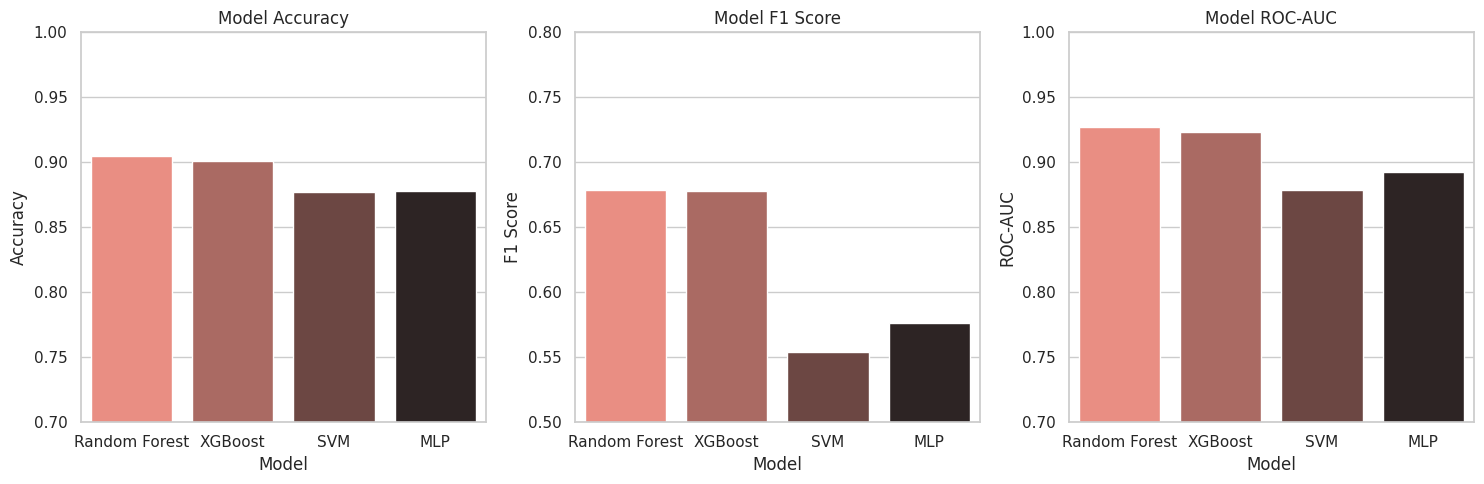

In [62]:
# accuracy, f1, and roc-auc
plt.figure(figsize=(15, 5))
sns.set(style="whitegrid")
plt.subplot(1, 3, 1)
sns.barplot(x='Model', y='Accuracy', data=df_metrics, palette='dark:salmon_r')
plt.title('Model Accuracy')
plt.ylim(0.7, 1)
plt.ylabel('Accuracy')
plt.xlabel('Model')

plt.subplot(1, 3, 2)
sns.barplot(x='Model', y='F1 Score', data=df_metrics, palette='dark:salmon_r')
plt.title('Model F1 Score')
plt.ylim(0.5, .8)
plt.ylabel('F1 Score')
plt.xlabel('Model')

plt.subplot(1, 3, 3)
sns.barplot(x='Model', y='ROC-AUC', data=df_metrics, palette='dark:salmon_r')
plt.title('Model ROC-AUC')
plt.ylim(0.7, 1)
plt.ylabel('ROC-AUC')
plt.xlabel('Model')
plt.tight_layout()
plt.show()

# Random Forest is still the best model

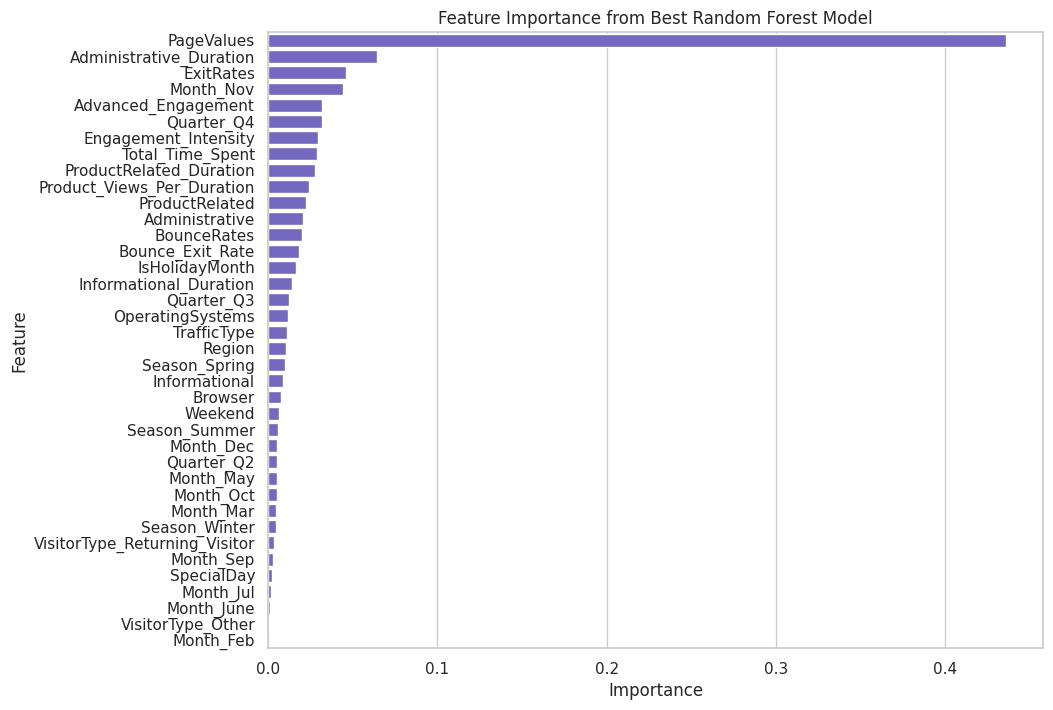

In [44]:
# Feature Importance Analysis
importances = best_rf_model.feature_importances_
features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, color='slateblue')
plt.title('Feature Importance from Best Random Forest Model')
plt.show()